<a href="https://colab.research.google.com/github/jedkk/Machine-Learning/blob/main/sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.


# Import Libraries and get Data

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

In [ ]:
#!pip install nltk
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional, Flatten, InputLayer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2021-05-30 07:43:43--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.04s   

2021-05-30 07:43:43 (9.21 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2021-05-30 07:43:43--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

# Data Exploration

In [ ]:
train_data = pd.read_csv(train_file_path, sep='\t', header=None, names=['label', 'message'])
test_data = pd.read_csv(test_file_path, sep='\t', header=None, names=['label', 'message'])

In [ ]:
train_data.head()

,label,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [ ]:
test_data.head()

,label,message
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [ ]:
train_data.groupby('label').describe().T

label                              ham                                               spam
message count                     3619                                                560
        unique                    3430                                                505
        top     sorry, i'll call later  hmv bonus special 500 pounds of genuine hmv vo...
        freq                        22                                                  3

In [ ]:
train_data.label.value_counts()

ham     3619
spam     560
Name: label, dtype: int64

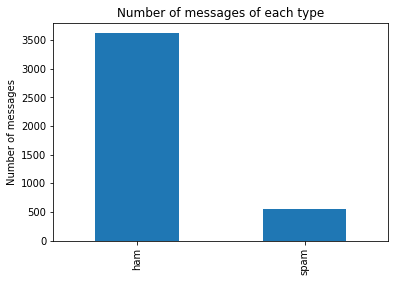

In [ ]:
train_data['label'].value_counts().sort_values(ascending=False).plot(kind='bar', ylabel='Number of messages', title='Number of messages of each type')

In [ ]:
ham_msg_train = train_data[train_data.label =='ham']
spam_msg_train = train_data[train_data.label=='spam']
# Downsampling to handle inbalance of data
ham_msg_train_df = ham_msg_train.sample(n = len(spam_msg_train), random_state = 44)
spam_msg_train_df = spam_msg_train
print(ham_msg_train_df.shape, spam_msg_train_df.shape)

(560, 2) (560, 2)


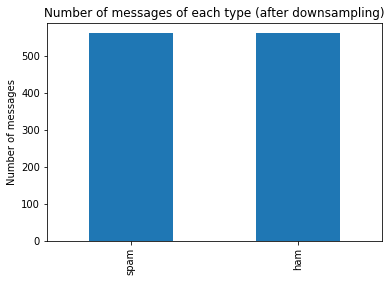

In [ ]:
msg_train_df = ham_msg_train_df.append(spam_msg_train_df).reset_index(drop=True)
msg_train_df['label'].value_counts().sort_values(ascending=False).plot(kind='bar', ylabel='Number of messages', title='Number of messages of each type (after downsampling)')

In [ ]:
#Count length of messages
msg_train_df['text_length'] = msg_train_df['message'].apply(len)

# Map ham label as 0 and spam as 1
msg_train_df['msg_type'] = msg_train_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_train_df['msg_type'].values

#Calculate average length by label types
labels = msg_train_df.groupby('label').mean()
labels

,text_length,msg_type
label,,
ham,70.823214,0.0
spam,138.750000,1.0


In [ ]:
# Map ham label as 0 and spam as 1 for test data
test_data['msg_type'] = test_data['label'].map({'ham': 0, 'spam': 1})

# Text Cleaning

In [ ]:
# look at a message
def print_plot(index):
  eg = train_data[train_data.index == index][['message', 'label']].values[0]
  if len(eg) > 0:
    print(eg[0])
    print('msg_type:', eg[1])

In [ ]:
print_plot(1000)

you please give us connection today itself before  &lt;decimal&gt;  or refund the bill
msg_type: ham


In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\~@,;]')
BAD_SYMBOLS_RE = re.compile('[^a-z #+_]') # remove numbers as well
STOPWORDS = set(stopwords.words('english'))

In [ ]:
len(STOPWORDS)

179

In [ ]:
def clean_text(text):
  text = text.lower()
  text = re.sub('&lt;/?[a-z]+&gt;', '', text) # removes html styles
  text = REPLACE_BY_SPACE_RE.sub(' ', text) # removes brackets and braces
  text = BAD_SYMBOLS_RE.sub('', text) # removes unusual characters
  text = ' '.join(word for word in text.split() if word not in STOPWORDS)
  return text

In [ ]:
clean_text("free loans, call 90201010!")

'free loans call'

In [ ]:
# cleaning 'msg' in both train and test data
msg_train_df['message'] = msg_train_df['message'].apply(clean_text)
#train_data['msg'] = train_data['msg'].str.replace('\d+', '')
test_data['message'] = test_data['message'].apply(clean_text)
#test_data['msg'] = test_data['msg'].str.replace('\d+', '')

# Encoding Text

In [ ]:
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(msg_train_df['message'])
word_index = tokenizer.word_index
len(word_index)

3999

In [ ]:
train_labels, test_labels = msg_train_df.pop('msg_type'), test_data.pop('msg_type')

In [ ]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(msg_train_df['message'])
training_padded = pad_sequences(training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)
testing_sequences = tokenizer.texts_to_sequences(test_data['message'])
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [ ]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1120, 50)
Shape of testing tensor:  (1392, 50)


# General Model params

In [ ]:
# Model parameters
embedding_dim = 16
drop_value = 0.2 
n_dense = 24

# Model 1 (with prediction values for test below as follows)
       [0.03264719],
       [0.04728591],
       [0.99933374],
       [0.65935117]
and with loss: 0.126, accuracy: 0.967

In [ ]:
# Model
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(GlobalAveragePooling1D())
model1.add(Dense(24, activation='relu'))
model1.add(Dropout(drop_value))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [ ]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
history1 = model1.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels), callbacks=[early_stop], verbose=1)

Epoch 1/30
35/35 [==============================] - 1s 7ms/step - loss: 0.6921 - accuracy: 0.5607 - val_loss: 0.6846 - val_accuracy: 0.9052
Epoch 2/30
35/35 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.5250 - val_loss: 0.6495 - val_accuracy: 0.8685
Epoch 3/30
35/35 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.6241 - val_loss: 0.6329 - val_accuracy: 0.9361
Epoch 4/30
35/35 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.7625 - val_loss: 0.5810 - val_accuracy: 0.9404
Epoch 5/30
35/35 [==============================] - 0s 4ms/step - loss: 0.5984 - accuracy: 0.8304 - val_loss: 0.5147 - val_accuracy: 0.9490
Epoch 6/30
35/35 [==============================] - 0s 4ms/step - loss: 0.5388 - accuracy: 0.8705 - val_loss: 0.4522 - val_accuracy: 0.9511
Epoch 7/30
35/35 [==============================] - 0s 4ms/step - loss: 0.4713 - accuracy: 0.9018 - val_loss: 0.3949 - val_accuracy: 0.9504
Epoch 8/30
35/35 [==

In [ ]:
accr = model1.evaluate(testing_padded, test_labels)
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

44/44 [==============================] - 0s 1ms/step - loss: 0.1259 - accuracy: 0.9670
Test set
 Loss: 0.126
 Accuracy: 0.967


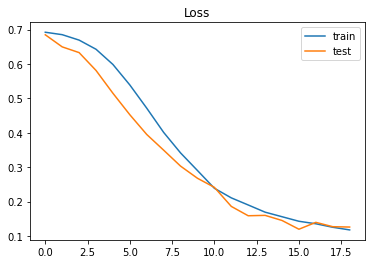

In [ ]:
plt.title('Loss')
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.show();

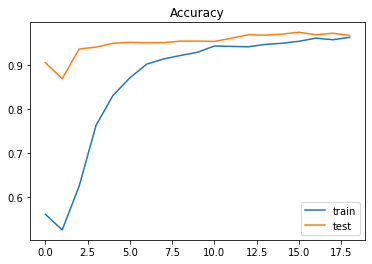

In [ ]:
plt.title('Accuracy')
plt.plot(history1.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# LSTM params

In [ ]:
#LSTM hyperparameters
n_lstm = 20
drop_lstm =0.2

# Model 2 (with prediction values for test below as follows)
       [0.00854081],
       [0.00838196],
       [0.9959605 ],
       [0.99555564]
 with loss: 0.260, accuracy: 0.929

In [ ]:
#LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model2.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model2.add(LSTM(n_lstm, dropout=drop_lstm))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 16)            8000      
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 20)            2960      
_________________________________________________________________
lstm_4 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               5376      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 19,873
Trainable params: 19,873
Non-trainable params: 0
__________________________________________________

In [ ]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history2 = model2.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels), callbacks=[early_stop], verbose=1)

Epoch 1/30
35/35 [==============================] - 5s 59ms/step - loss: 0.6935 - accuracy: 0.4946 - val_loss: 0.6868 - val_accuracy: 0.8657
Epoch 2/30
35/35 [==============================] - 1s 39ms/step - loss: 0.6933 - accuracy: 0.4938 - val_loss: 0.6931 - val_accuracy: 0.8700
Epoch 3/30
35/35 [==============================] - 1s 38ms/step - loss: 0.6442 - accuracy: 0.6170 - val_loss: 0.2720 - val_accuracy: 0.8728
Epoch 4/30
35/35 [==============================] - 1s 38ms/step - loss: 0.2481 - accuracy: 0.9277 - val_loss: 0.3225 - val_accuracy: 0.9045
Epoch 5/30
35/35 [==============================] - 1s 37ms/step - loss: 0.1530 - accuracy: 0.9545 - val_loss: 0.1538 - val_accuracy: 0.9569
Epoch 6/30
35/35 [==============================] - 1s 38ms/step - loss: 0.1071 - accuracy: 0.9652 - val_loss: 0.1352 - val_accuracy: 0.9461
Epoch 7/30
35/35 [==============================] - 1s 38ms/step - loss: 0.1123 - accuracy: 0.9625 - val_loss: 0.2338 - val_accuracy: 0.9332
Epoch 8/30
35

In [ ]:
accr2 = model2.evaluate(testing_padded, test_labels)
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr2[0], accr2[1]))

44/44 [==============================] - 0s 9ms/step - loss: 0.2598 - accuracy: 0.9289
Test set
 Loss: 0.260
 Accuracy: 0.929


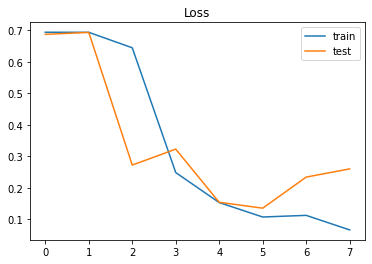

In [ ]:
plt.title('Loss')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show();

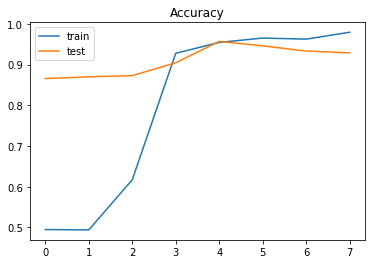

In [ ]:
plt.title('Accuracy')
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# Model 3 (with prediction values for test below as follows)
       [0.0051049 ],
       [0.00462869],
       [0.99995565],
       [0.9872968 ]
with loss: 0.103, accuracy: 0.964

In [ ]:
# Biderectional LSTM Spam detection architecture
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model3.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model3.add(Dropout(0.5))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 16)            8000      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                5920      
_________________________________________________________________
dropout_4 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2624      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 16,609
Trainable params: 16,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history3 = model3.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks=[early_stop], verbose=1)

Epoch 1/30
35/35 [==============================] - 5s 57ms/step - loss: 0.6842 - accuracy: 0.6295 - val_loss: 0.6617 - val_accuracy: 0.8858
Epoch 2/30
35/35 [==============================] - 1s 28ms/step - loss: 0.5184 - accuracy: 0.8464 - val_loss: 0.2368 - val_accuracy: 0.9246
Epoch 3/30
35/35 [==============================] - 1s 28ms/step - loss: 0.2476 - accuracy: 0.9152 - val_loss: 0.1053 - val_accuracy: 0.9727
Epoch 4/30
35/35 [==============================] - 1s 29ms/step - loss: 0.1678 - accuracy: 0.9482 - val_loss: 0.1273 - val_accuracy: 0.9641
Epoch 5/30
35/35 [==============================] - 1s 28ms/step - loss: 0.1209 - accuracy: 0.9616 - val_loss: 0.0680 - val_accuracy: 0.9777
Epoch 6/30
35/35 [==============================] - 1s 29ms/step - loss: 0.0988 - accuracy: 0.9643 - val_loss: 0.1488 - val_accuracy: 0.9504
Epoch 7/30
35/35 [==============================] - 1s 29ms/step - loss: 0.0832 - accuracy: 0.9750 - val_loss: 0.1030 - val_accuracy: 0.9641


In [ ]:
accr3 = model3.evaluate(testing_padded, test_labels)
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr3[0], accr3[1]))

44/44 [==============================] - 0s 7ms/step - loss: 0.1030 - accuracy: 0.9641
Test set
 Loss: 0.103
 Accuracy: 0.964


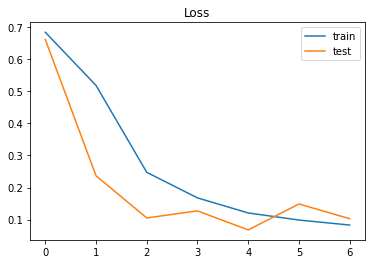

In [ ]:
plt.title('Loss')
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='test')
plt.legend()
plt.show();

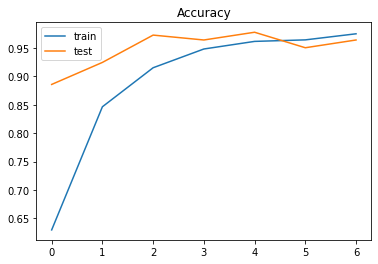

In [ ]:
plt.title('Accuracy')
plt.plot(history3.history['accuracy'], label='train')
plt.plot(history3.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# Model 4: Using TextVectorization layer (with prediction values for test below as follows) 
       [3.2508306e-05],
       [6.3517690e-04],
       [9.9999213e-01],
       [9.8503435e-01]
with loss: 0.186, accuracy: 0.945


In [ ]:
train_data.iloc[1000, 1]

'you please give us connection today itself before  &lt;decimal&gt;  or refund the bill'

In [ ]:
'''
def normalize(text):
  remove_regex = f'[{re.escape(string.punctuation)}]'
  space_regex = '...'
  result = tf.strings.lower(text)
  result = tf.strings.regex_replace(result, remove_regex, '')
  result = tf.strings.regex_replace(result, space_regex, ' ')
  return result
'''

In [ ]:
### Text encoder #1
#BUFFER_SIZE = 10000
#BATCH_SIZE = 64
#train_data = train_data['msg'].shuffle(BUFFER_SIZE).prefetch(tf.data.AUTOTUNE)
#test_data = test_data['msg'].batch(BATCH_SIZE).prefetch(tf.data.AUTOTONE)
VOCAB_SIZE = 1000
encoder = keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=max_len)
encoder.adapt(msg_train_df['message'].tolist()) # set layer's vocabulary


# to take a look at the vocabulary
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'call', 'u', 'free', 'ur', 'txt', 'p', 'get', 'text',
       'mobile', 'stop', 'reply', 'claim', 'im', 'go', 'send', 'new',
       'nokia', 'prize'], dtype='<U21')

In [ ]:
## output_dim = input_dim ** 0.25 ~= 9 based on stackexchange

In [ ]:
#MAX_TOKENS_NUM = 5000  # Maximum vocab size.
#MAX_SEQUENCE_LEN = 40  # Sequence length to pad the outputs to.
#EMBEDDING_DIMS = 100

model = Sequential()
model.add(InputLayer(input_shape=(1,), dtype=tf.string))
model.add(encoder)
model.add(Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=embedding_dim, mask_zero=True)) # embedding dim change to 64 if needed
model.add(Bidirectional(LSTM(64, dropout=drop_lstm, return_sequences=True)))
model.add(Bidirectional(LSTM(32, dropout=drop_lstm)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_10 (ModuleWra (None, 50)                0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 50, 16)            16000     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 50, 128)           41472     
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)               

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
train_dataset, train_label = msg_train_df['message'], msg_train_df['msg_type']
test_dataset, test_label = test_data['message'], test_data['msg_type']

In [ ]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(train_dataset, train_label, epochs=num_epochs, 
                    validation_data=(test_dataset, test_label),callbacks =[early_stop], verbose=1)

Epoch 1/30
35/35 [==============================] - 53s 315ms/step - loss: 0.6305 - accuracy: 0.5777 - val_loss: 0.5955 - val_accuracy: 0.9059
Epoch 2/30
35/35 [==============================] - 6s 163ms/step - loss: 0.3330 - accuracy: 0.9357 - val_loss: 0.3004 - val_accuracy: 0.9540
Epoch 3/30
35/35 [==============================] - 6s 162ms/step - loss: 0.1732 - accuracy: 0.9634 - val_loss: 0.2292 - val_accuracy: 0.9562
Epoch 4/30
35/35 [==============================] - 6s 165ms/step - loss: 0.0967 - accuracy: 0.9795 - val_loss: 0.1682 - val_accuracy: 0.9576
Epoch 5/30
35/35 [==============================] - 6s 165ms/step - loss: 0.0539 - accuracy: 0.9866 - val_loss: 0.1570 - val_accuracy: 0.9634
Epoch 6/30
35/35 [==============================] - 6s 171ms/step - loss: 0.0309 - accuracy: 0.9955 - val_loss: 0.1196 - val_accuracy: 0.9720
Epoch 7/30
35/35 [==============================] - 6s 172ms/step - loss: 0.0238 - accuracy: 0.9937 - val_loss: 0.1775 - val_accuracy: 0.9634
Epoch

In [ ]:
accr = model.evaluate(test_dataset, test_label)
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

44/44 [==============================] - 1s 32ms/step - loss: 0.1859 - accuracy: 0.9454
Test set
 Loss: 0.186
 Accuracy: 0.945


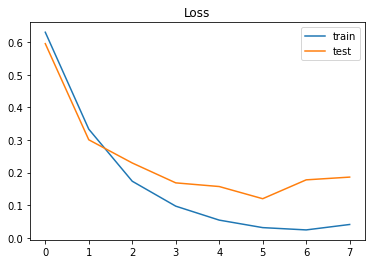

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

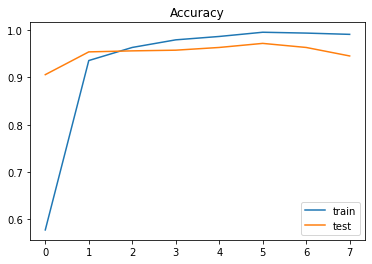

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
predictions = model.predict(np.array(predict_msg))
print(predictions)

[[3.2508306e-05]
 [6.3517690e-04]
 [9.9999213e-01]
 [9.8503435e-01]]


In [ ]:
def predict_message(pred_text):
  pred = model.predict(np.array([pred_text])).astype("float32").item()
  labels = ['ham', 'spam']
  prediction = [pred, labels[round(pred)]]
  return prediction

#pred_text = "how are you doing today?"
pred_text = "sale today! to stop texts call 98912460324"

prediction = predict_message(pred_text)
print(prediction)

[0.9850343465805054, 'spam']


# Test/Prediction

In [ ]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
          "sale today! to stop texts call 98912460324"]

In [ ]:
# applying conditional value of 0.5 to get 0 or 1 as output
sms = ["We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB "]
sms_proc = tokenizer.texts_to_sequences(sms)
sms_proc = pad_sequences(sms_proc, maxlen=max_len, padding=padding_type, truncating=trunc_type)
pred = (model3.predict(sms_proc) > 0.5).astype("int32").item() # change model accordingly to test
print(pred)

1


In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
# For model 1, 2 and 3
def predict_message(pred_text):
  sms_proc = tokenizer.texts_to_sequences([pred_text])
  sms_proc = pad_sequences(sms_proc, maxlen=max_len, padding=padding_type, truncating=trunc_type)
  pred = model3.predict(sms_proc).astype("float32").item()
  labels = ['ham', 'spam']
  prediction = [pred, labels[round(pred)]]
  return prediction

pred_text = "how are you doing today?"
#pred_text = "sale today! to stop texts call 98912460324"

prediction = predict_message(pred_text)
print(prediction)

[0.011980623006820679, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
